# Dams in Columbia River Network

In [1]:
import warnings
from pathlib import Path

warnings.filterwarnings("ignore", message=".*initial implementation of Parquet.*")
root = Path("input_data")
root.mkdir(parents=True, exist_ok=True)
BASE_PLOT = {"facecolor": "k", "edgecolor": "b", "alpha": 0.2, "figsize": (18, 9)}
CRS = "esri:102008"

#### Basin

In [2]:
import geopandas as gpd

import pynhd as nhd

nldi = nhd.NLDI()
station_id = "14246900"
cfile = Path(root, f"basin_{station_id}.feather")
if cfile.exists():
    basin = gpd.read_feather(cfile)
else:
    basin = nldi.get_basins(station_id)
    basin.to_feather(cfile)

#### Main

In [3]:
cfile = Path(root, f"flowline_main_{station_id}.feather")
if cfile.exists():
    flw_main = gpd.read_feather(cfile)
else:
    flw_main = nldi.navigate_byid(
        fsource="nwissite",
        fid=f"USGS-{station_id}",
        navigation="upstreamMain",
        source="flowlines",
        distance=2000,
    )
    flw_main.to_feather(cfile)

#### Tributaries

In [4]:
cfile = Path(root, f"flowline_trib_{station_id}.feather")
if cfile.exists():
    flw_trib = gpd.read_feather(cfile)
else:
    flw_trib = nldi.navigate_byid(
        fsource="nwissite",
        fid=f"USGS-{station_id}",
        navigation="upstreamTributaries",
        source="flowlines",
        distance=2000,
    )
    flw_trib.to_feather(cfile)
flw_trib["nhdplus_comid"] = flw_trib["nhdplus_comid"].astype("float").astype("Int64")

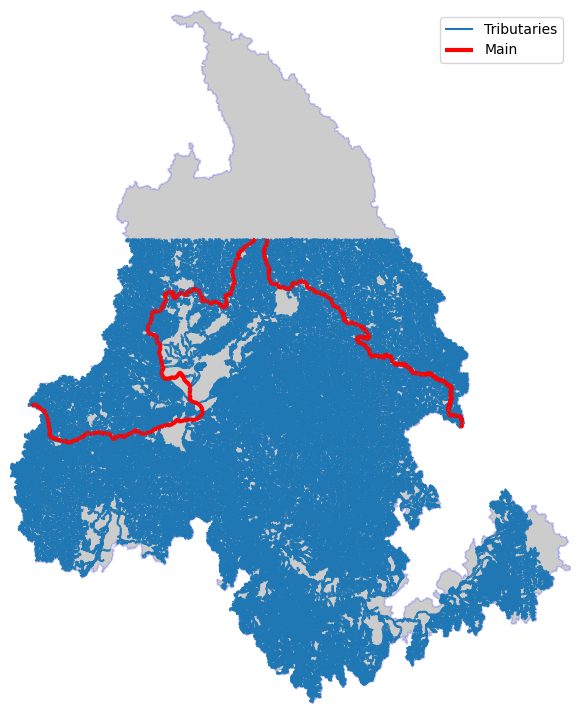

In [5]:
ax = basin.plot(**BASE_PLOT)
flw_trib.plot(ax=ax)
flw_main.plot(ax=ax, lw=3, color="r")
ax.legend(["Tributaries", "Main"])
ax.axis("off")
ax.margins(0)

#### Accumulated Dams

In [6]:
import pandas as pd

cfile = Path(root, "nid_flw.pkl")

if cfile.exists():
    nid_flw = pd.read_pickle(cfile)
else:
    meta = nhd.nhdplus_attrs()
    nid_years = (
        meta[meta.description.str.contains("dam", case=False)].sort_values("name").name.tolist()
    )
    nid_flw = {n.split("_")[-1]: nhd.nhdplus_attrs(n) for n in nid_years}
    pd.to_pickle(nid_flw, cfile)

Now, let's see what catchment-level characteristics are available that are related to dams.

In [7]:
div_chars = nldi.valid_characteristics
div_chars[div_chars.characteristic_description.str.contains("dam")]

,characteristic_id,characteristic_description,units,dataset_label,dataset_url,theme_label,theme_url,characteristic_type
102,CAT_NORM_STORAGE2013,The normal dam storage (in acre-feet) defined ...,acre-feet,Number of major dams built on or before YYYY i...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,localCatch_name
118,CAT_MAJOR2013,Number of major dams built on or before YYYY i...,count,Number of major dams built on or before YYYY i...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,localCatch_name
120,CAT_NDAMS2013,"Number of dams built on or before YYYY ,",count,Number of major dams built on or before YYYY i...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,localCatch_name
121,CAT_NID_STORAGE2013,The maximum dam storage (in acre-feet) defined...,acre-feet,Number of major dams built on or before YYYY i...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,localCatch_name
247,ACC_NDAMS2013,"Number of dams built on or before YYYY ,",count,Number of major dams built on or before YYYY i...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,divRoute_name
248,ACC_NID_STORAGE2013,The maximum dam storage (in acre-feet) defined...,acre-feet,Number of major dams built on or before YYYY i...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,divRoute_name
249,ACC_NORM_STORAGE2013,The normal dam storage (in acre-feet) defined ...,acre-feet,Number of major dams built on or before YYYY i...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,divRoute_name
250,ACC_MAJOR2013,Number of major dams built on or before YYYY i...,count,Number of major dams built on or before YYYY i...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,divRoute_name
374,TOT_NDAMS2013,"Number of dams built on or before YYYY ,",count,Number of major dams built on or before YYYY i...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,totRoute_name
375,TOT_NID_STORAGE2013,The maximum dam storage (in acre-feet) defined...,acre-feet,Number of major dams built on or before YYYY i...,https://www.sciencebase.gov/catalog/item/58c30...,Hydrologic Modifications,unknown,totRoute_name


Let's get `ACC_NID_STORAGE2013`:

We can achieve the same results using another function that uses `ScienceBase` instead of `NLDI`:

```python
nid_vals = nldi.getcharacteristic_byid(flw_trib.nhdplus_comid.tolist(), "div", "ACC_NID_STORAGE2013")
```
```python
comids = [int(c) for c in flw_trib.nhdplus_comid.tolist()]
nid_vals = {
    yr: df.loc[df.COMID.isin(comids), ["COMID", f"ACC_NID_STORAGE{yr}", f"ACC_NDAMS{yr}"]].rename(
        columns={
            "COMID": "comid",
            f"ACC_NID_STORAGE{yr}": "smax",
            f"ACC_NDAMS{yr}": "ndams",
        }
    )
    for yr, df in nid_flw.items()
}
nid_vals = pd.concat(nid_vals).reset_index().drop(columns="level_1")
nid_vals = nid_vals.rename(columns={"level_0": "year"}).astype({"year": int})
```

In [8]:
comids = [int(c) for c in flw_trib.nhdplus_comid.tolist()]
nid_vals = {
    yr: df.loc[df.COMID.isin(comids), ["COMID", f"ACC_NID_STORAGE{yr}", f"ACC_NDAMS{yr}"]].rename(
        columns={
            "COMID": "comid",
            f"ACC_NID_STORAGE{yr}": "smax",
            f"ACC_NDAMS{yr}": "ndams",
        }
    )
    for yr, df in nid_flw.items()
}
nid_vals = pd.concat(nid_vals).reset_index().drop(columns="level_1")
nid_vals = nid_vals.rename(columns={"level_0": "year"}).astype({"year": int})

#### Accumulated Max Storage

In [9]:
nid_vals = (
    nid_vals.set_index("comid")
    .merge(
        flw_trib.astype({"nhdplus_comid": int}).set_index("nhdplus_comid"),
        left_index=True,
        right_index=True,
        suffixes=(None, None),
    )
    .reset_index()
    .rename(columns={"index": "comid"})
)
smax = nid_vals.groupby(["year", "comid"]).sum(numeric_only=True)["smax"].unstack()
smax = gpd.GeoDataFrame(
    smax.T.merge(
        flw_trib.astype({"nhdplus_comid": int}).set_index("nhdplus_comid"),
        left_index=True,
        right_index=True,
        suffixes=(None, None),
    )
)

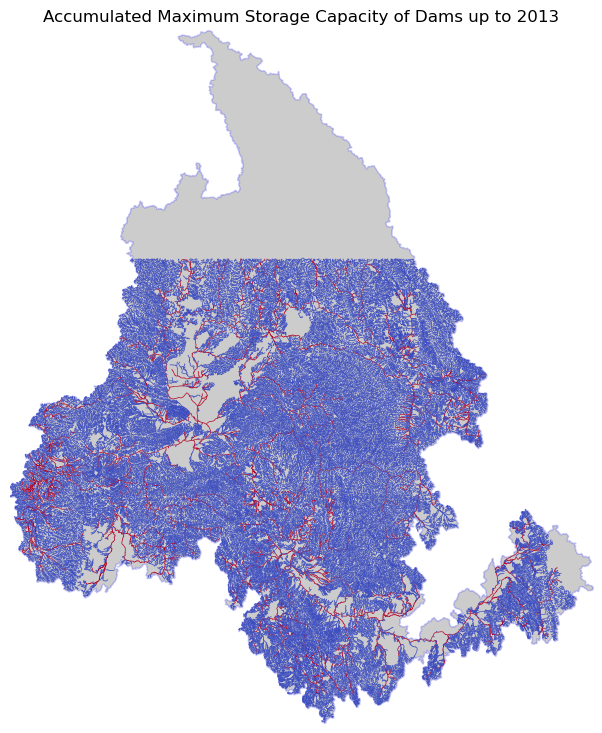

In [10]:
yr = 2013
ax = basin.plot(**BASE_PLOT)
smax.plot(ax=ax, scheme="Quantiles", k=2, column=yr, cmap="coolwarm", lw=0.5, legend=False)
ax.set_title(f"Accumulated Maximum Storage Capacity of Dams up to {yr}")
ax.axis("off")
ax.margins(0)
ax.figure.savefig(Path("_static", "columbia.png"), dpi=300, bbox_inches="tight", facecolor="w")